In [1]:
import sys
sys.path.append("../../src")
import os
import numpy as np
import pickle
from autoencoder import full_network
from training import create_feed_dictionary, create_feed_dictionary2, eval_model, max_err_heatmap
from sindy_utils import *
from error_utils import *
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from time import time
%matplotlib inline
from copy import deepcopy
import subprocess as sp
from error_utils import residual_2Dburger
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FormatStrFormatter

def get_cmap(n, name='tab20'):
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(10)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def get_gpu_memory():
  _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

  ACCEPTABLE_AVAILABLE_MEMORY = 1024
  COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
  memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
  memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
  return memory_free_values

device_list = tf.config.list_physical_devices('GPU')
free_mem = get_gpu_memory()
for i,gpu in enumerate(device_list):
    print(f'{gpu}: free memory: {free_mem[i]}')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): free memory: 15758
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'): free memory: 16124
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'): free memory: 16123
PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'): free memory: 16124


In [3]:
# specify which GPU to use
config = tf.ConfigProto(log_device_placement=False, gpu_options=tf.GPUOptions(allow_growth=True,
                                                                              visible_device_list='1'))

## Load the Trained gLaSDI

In [4]:
data_path = os.getcwd() + '/fig/test/'
save_name = 'burger_2022_05_18_21_16_40'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name
params['config'] = config

## Evaluation by One Parameter Case

In [5]:
def process_data(data, vel, nt):
    # select component
    if vel == 1:
        data['data'][0]['x'] = data['data'][0].pop('u')
        data['data'][0]['dx'] = data['data'][0].pop('du')
        data['data'][0].pop('v')
        data['data'][0].pop('dv')
    elif vel == 2:
        data['data'][0]['x'] = data['data'][0].pop('v')
        data['data'][0]['dx'] = data['data'][0].pop('dv')
        data['data'][0].pop('u')
        data['data'][0].pop('du')
    elif vel == 3:
        data['data'][0]['x'] = np.hstack((data['data'][0]['u'], data['data'][0]['v']))
        data['data'][0]['dx'] = np.hstack((data['data'][0]['du'], data['data'][0]['dv']))
        
    # select time steps
    data['data'][0]['x'] = data['data'][0]['x'][:nt+1]
    data['data'][0]['dx'] = data['data'][0]['dx'][:nt+1]
    data_x = np.copy(data['data'][0]['x'])
    data_dx = np.copy(data['data'][0]['dx'])
    return data, data_x, data_dx

In [6]:
Re = params['pde']['Re']
nx = params['pde']['nx']
ny = nx
nt = params['pde']['nt']
tstop = params['pde']['tstop']
ic = params['pde']['ic']
t_test = tstop
vel = 3 # 1: u, 2: v, 3: u and v
knn = 1
amp_arr = np.array([0.7])
width_arr = np.array([0.9])
test_data = pickle.load(open(f"/g/g92/he10/Research/data/2DBurgerEqn/local1_Re{Re}_A{amp_arr[0]:.2f}_W{width_arr[0]:.2f}_tstop{tstop:.1f}_nt{nt}_nx{nx}.p", "rb"))

In [7]:
nt_test = int(t_test/tstop*nt)
t = np.linspace(0,t_test,nt_test+1)
test_data, test_data_x, test_data_dx = process_data(test_data, vel, nt_test)

u_decoder,du_decoder,u_sim,du_sim,z_encoder,dz_encoder,z_sim,dz_sim,idx,timer_rom = eval_model(test_data['data'][0], params,
                                                                                               test_data['param'][0], knn=knn,
                                                                                               calc_dz=True, calc_du=True)
u_decoder = u_decoder.squeeze()
time_rom = timer_rom[1:].sum()
print(z_sim.shape, u_sim.shape, u_decoder.shape)
print(f'time: {time_rom:.2f} s')

(201, 5) (201, 7200) (201, 7200)
time: 0.03 s


In [8]:
# max relative error
err_decoder = np.linalg.norm(test_data_x - u_decoder, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
err_sindy = np.linalg.norm(test_data_x - u_sim, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
print(f'max autoencoder error: {err_decoder.max():.2f} %')
print(f'max sindy-decoder error: {err_sindy.max():.2f} %')

max autoencoder error: 0.70 %
max sindy-decoder error: 1.27 %


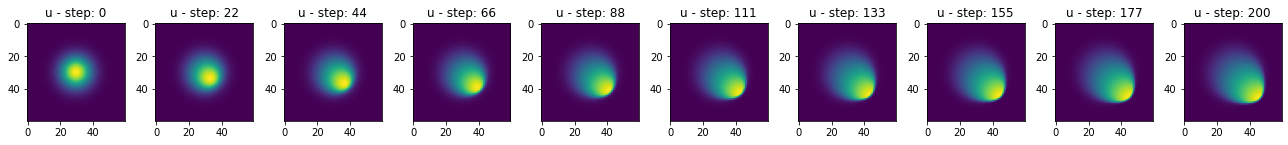

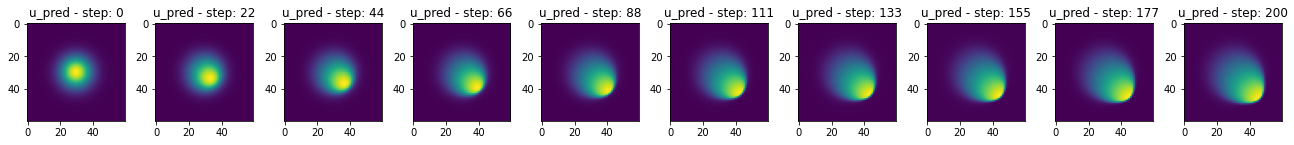

In [9]:
step_list = np.linspace(0,nt_test,10).astype(int)
fig = plt.figure(figsize=(18,3))
for i,step in enumerate(step_list):
    ax = fig.add_subplot(1,10,i+1)
    ax.imshow(test_data_x[step,:nx*ny].reshape(ny,nx))
    ax.set_title(f'u - step: {step}')
plt.tight_layout()

fig = plt.figure(figsize=(18,3))
for i,step in enumerate(step_list):
    ax = fig.add_subplot(1,10,i+1)
    ax.imshow(u_sim[step,:nx*ny].reshape(ny,nx))
    ax.set_title(f'u_pred - step: {step}')
plt.tight_layout()

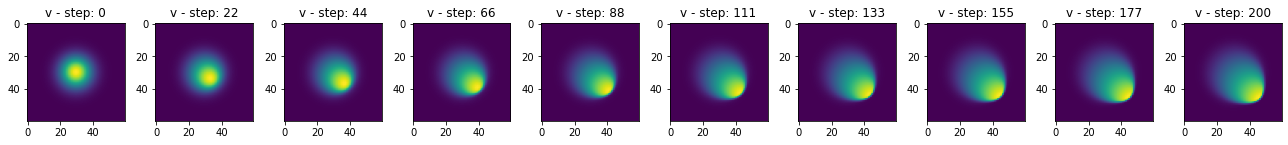

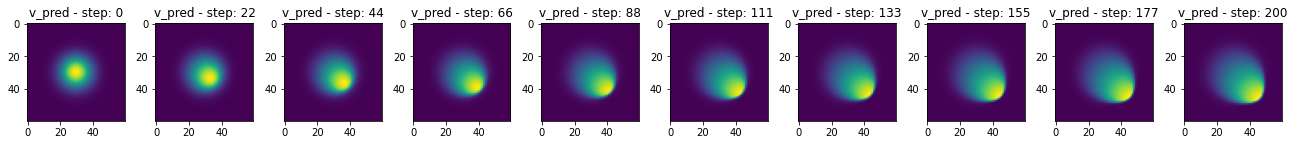

In [10]:
step_list = np.linspace(0,nt_test,10).astype(int)
fig = plt.figure(figsize=(18,3))
for i,step in enumerate(step_list):
    ax = fig.add_subplot(1,10,i+1)
    ax.imshow(test_data_x[step,nx*ny:].reshape(ny,nx))
    ax.set_title(f'v - step: {step}')
plt.tight_layout()

fig = plt.figure(figsize=(18,3))
for i,step in enumerate(step_list):
    ax = fig.add_subplot(1,10,i+1)
    ax.imshow(u_sim[step,nx*ny:].reshape(ny,nx))
    ax.set_title(f'v_pred - step: {step}')
plt.tight_layout()

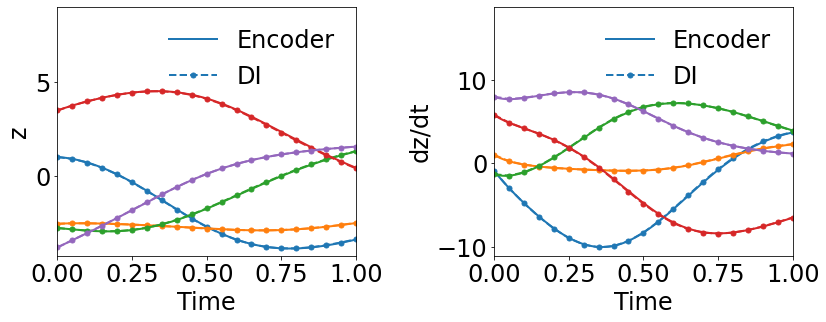

In [11]:
plt.rcParams.update({"font.size": 24,
                     "font.family": "sans-serif"}) # fontsize for figures

fig1 = plt.figure(figsize=(12,5))
line_type = ['-','-*','-.','-^','-s']
idx = np.arange(0,t.size,10)
ax = fig1.add_subplot(121)
for i in range(z_encoder.shape[1]):
    ax.plot(t, z_encoder[:,i], '-', lw=2, c=cmap(i))
    ax.plot(t[idx], z_sim[idx,i], '--o', lw=2, markersize=5, c=cmap(i))
ax.set_xlabel('Time')
ax.set_ylabel('z')
ax.set_xticks(np.linspace(0,t.max(),5))
ax.set_ylim(z_sim.min()*1.1,z_sim.max()*2)
ax.tick_params(axis='both', labelsize=24)
ax.legend(['Encoder', 'DI'], loc='upper right', frameon=False, fontsize=24)
ax.set_xlim(t.min(),t.max())

ax = fig1.add_subplot(122)
for i in range(z_sim.shape[1]):
    ax.plot(t, dz_encoder[:,i], '-', linewidth=2, c=cmap(i))
    ax.plot(t[idx], dz_sim[idx,i], '--o', linewidth=2, markersize=5, c=cmap(i))
ax.set_xlabel('Time')
ax.set_ylabel('dz/dt')
ax.set_xticks(np.linspace(0,t.max(),5))
ax.set_xlim(0,t.max())
ax.set_ylim(dz_sim.min()*1.1,dz_sim.max()*2.2)
ax.tick_params(axis='both', labelsize=24)
ax.legend(['Encoder', 'DI'], loc='upper right', frameon=False, fontsize=24)

plt.tight_layout()
# plt.savefig(data_path + f"2Dburger_latent_dynamics.png",bbox_inches='tight')

## Evaluation by the Prescribed Parameter Space

In [12]:
knn = 3
res_name = f'mean'
nt_test = int(t_test/tstop*nt)
t = np.linspace(0,t_test,nt_test+1)
vel = 3 # 1: u, 2: v, 3: u and v

amp_test = params['test_param'][:,0]
width_test = params['test_param'][:,1]
amp_size = amp_test.size
width_size = width_test.size
num_case = amp_size * width_size
max_err = np.zeros([amp_size, width_size])
res_norm = np.zeros([amp_size, width_size])
sindy_idx = np.zeros([amp_size, width_size])
test_data_all = pickle.load(open(f"/g/g92/he10/Research/data/2DBurgerEqn/local{num_case}_Re{Re}_tstop{tstop:.1f}_nt{nt}_nx{nx}.p", "rb"))

speed_up = 0
count = 0
timer_rom = np.zeros(4)
start_time = time()
for i,a in enumerate(amp_test):
    for j,w in enumerate(width_test):
        print(f"{count+1}/{num_case}: {test_data_all['param'][count]}")
        test_data = {}
        test_data['data'] = [deepcopy(test_data_all['data'][count])]
        test_data['param'] = [deepcopy(test_data_all['param'][count])]
        test_data, test_data_x,_ = process_data(test_data, vel, nt_test)
        _,_,u_sim,_,_,_,_,_,idx,t_rom = eval_model(test_data['data'][0], params, 
                                                   test_data['param'][0], knn=knn)
        timer_rom += t_rom
        sindy_idx[i,j] = idx+1
        
        # max error of all time steps
        max_err[i,j] = (np.linalg.norm(test_data_x - u_sim, axis=1) \
                                        / np.linalg.norm(test_data_x, axis=1)*100).max()
        
        # residual norm
        res_norm[i,j] = err_indicator(u_sim, params, err_type=params['err_type'])
        count += 1
end_time = time()
time_rom = timer_rom[1:].sum()/num_case # from Step 2 to 4
time_sim = 38.4 # seconds
speed_up = time_sim / time_rom
print(f'Time taken: {end_time-start_time:.2f} s, {(end_time-start_time)/60:.2f} mins')
print(f'Average speed up: {speed_up:.2f}')

1/441: [0.7 0.9]
2/441: [0.7  0.91]
3/441: [0.7  0.92]
4/441: [0.7  0.93]
5/441: [0.7  0.94]
6/441: [0.7  0.95]
7/441: [0.7  0.96]
8/441: [0.7  0.97]
9/441: [0.7  0.98]
10/441: [0.7  0.99]
11/441: [0.7 1. ]
12/441: [0.7  1.01]
13/441: [0.7  1.02]
14/441: [0.7  1.03]
15/441: [0.7  1.04]
16/441: [0.7  1.05]
17/441: [0.7  1.06]
18/441: [0.7  1.07]
19/441: [0.7  1.08]
20/441: [0.7  1.09]
21/441: [0.7 1.1]
22/441: [0.71 0.9 ]
23/441: [0.71 0.91]
24/441: [0.71 0.92]
25/441: [0.71 0.93]
26/441: [0.71 0.94]
27/441: [0.71 0.95]
28/441: [0.71 0.96]
29/441: [0.71 0.97]
30/441: [0.71 0.98]
31/441: [0.71 0.99]
32/441: [0.71 1.  ]
33/441: [0.71 1.01]
34/441: [0.71 1.02]
35/441: [0.71 1.03]
36/441: [0.71 1.04]
37/441: [0.71 1.05]
38/441: [0.71 1.06]
39/441: [0.71 1.07]
40/441: [0.71 1.08]
41/441: [0.71 1.09]
42/441: [0.71 1.1 ]
43/441: [0.72 0.9 ]
44/441: [0.72 0.91]
45/441: [0.72 0.92]
46/441: [0.72 0.93]
47/441: [0.72 0.94]
48/441: [0.72 0.95]
49/441: [0.72 0.96]
50/441: [0.72 0.97]
51/441: [0.72 0

397/441: [0.88 1.08]
398/441: [0.88 1.09]
399/441: [0.88 1.1 ]
400/441: [0.89 0.9 ]
401/441: [0.89 0.91]
402/441: [0.89 0.92]
403/441: [0.89 0.93]
404/441: [0.89 0.94]
405/441: [0.89 0.95]
406/441: [0.89 0.96]
407/441: [0.89 0.97]
408/441: [0.89 0.98]
409/441: [0.89 0.99]
410/441: [0.89 1.  ]
411/441: [0.89 1.01]
412/441: [0.89 1.02]
413/441: [0.89 1.03]
414/441: [0.89 1.04]
415/441: [0.89 1.05]
416/441: [0.89 1.06]
417/441: [0.89 1.07]
418/441: [0.89 1.08]
419/441: [0.89 1.09]
420/441: [0.89 1.1 ]
421/441: [0.9 0.9]
422/441: [0.9  0.91]
423/441: [0.9  0.92]
424/441: [0.9  0.93]
425/441: [0.9  0.94]
426/441: [0.9  0.95]
427/441: [0.9  0.96]
428/441: [0.9  0.97]
429/441: [0.9  0.98]
430/441: [0.9  0.99]
431/441: [0.9 1. ]
432/441: [0.9  1.01]
433/441: [0.9  1.02]
434/441: [0.9  1.03]
435/441: [0.9  1.04]
436/441: [0.9  1.05]
437/441: [0.9  1.06]
438/441: [0.9  1.07]
439/441: [0.9  1.08]
440/441: [0.9  1.09]
441/441: [0.9 1.1]
Time taken: 1100.43 s, 18.34 mins
Average speed up: 1721.28


In [13]:
a_grid, w_grid = np.meshgrid(amp_test, width_test)
param_list = np.hstack([a_grid.flatten().reshape(-1,1), w_grid.flatten().reshape(-1,1)])
a_grid, w_grid = np.meshgrid(np.arange(amp_test.size), np.arange(width_test.size))
idx_list = np.hstack([a_grid.flatten().reshape(-1,1), w_grid.flatten().reshape(-1,1)])

idx_param = []
for i,ip in enumerate(params['param']):
    idx = np.argmin(np.linalg.norm(param_list-ip, axis=1))
    idx_param.append((idx, np.array([param_list[idx,0], param_list[idx,1]])))

In [14]:
max_err_train = []
res_norm_train = []
for i in idx_param:
    idd = i[0]
    max_err_train.append(max_err[idx_list[idd,0],idx_list[idd,1]])
    res_norm_train.append(res_norm[idx_list[idd,0],idx_list[idd,1]])
max_err_train = np.stack(max_err_train)
res_norm_train = np.stack(res_norm_train)
err_ratio_train = res_norm_train / max_err_train
err_ratio_train_mean = err_ratio_train.mean()
res_norm_tol = err_ratio_train_mean * params['tol2']
print(f'tolerance of residual norm (mean): {res_norm_tol:.5f}')
print(f"tolerance of residual norm (reg_max): {params['tol']:.5f}")

tolerance of residual norm (mean): 0.01845
tolerance of residual norm (reg_max): 0.02570


7.355981166319296


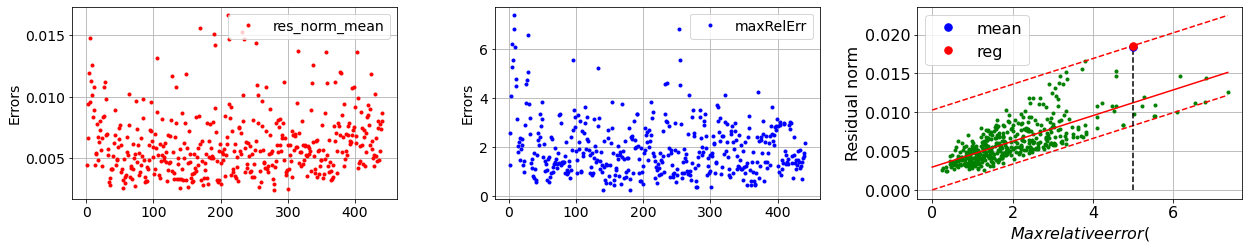

In [15]:
fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(131)
ax.plot(np.arange(1,res_norm.size+1), res_norm.flatten(), 'r.', label='res_norm_'+res_name)
ax.set_ylabel('Errors', fontsize=14)
ax.tick_params(labelsize=14)
ax.grid()
ax.legend(fontsize=14)

ax = fig.add_subplot(132)
ax.plot(np.arange(1,res_norm.size+1), max_err.flatten(), 'b.', label='maxRelErr')
ax.set_ylabel('Errors', fontsize=14)
ax.tick_params(labelsize=14)
ax.grid()
ax.legend(fontsize=14)

ax = fig.add_subplot(133)
x = max_err.flatten().reshape(-1,1)
y = res_norm.flatten().reshape(-1,1)
reg = LinearRegression().fit(x, y)
y_pred = reg.predict(x)
y_diff = y - y_pred
x_test = np.linspace(0,max_err.max(),2).reshape(-1,1)
y_test = reg.predict(x_test)
y_test1 = reg.coef_ * x_test + reg.intercept_+ y_diff.min()
y_test2 = reg.coef_ * x_test + reg.intercept_+ y_diff.max()
y_test3 = reg.coef_ * params['tol2'] + reg.intercept_+ y_diff.max()
ax.plot(max_err.flatten(), res_norm.flatten(), 'g.')
ax.plot(x_test,y_test,'r-')
ax.plot(x_test,y_test1,'r--')
ax.plot(x_test,y_test2,'r--')

x_test2 = np.linspace(0,params['tol2'],2).reshape(-1,1)
y_test2 = err_ratio_train_mean * x_test2
ax.plot([x_test2.max(),x_test2.max()],[0,max(y_test3,res_norm_tol)],'k--')
ax.plot(x_test2.max(),res_norm_tol,'b.',markersize=15, label='mean')
ax.plot(params['tol2'],y_test3,'r.',markersize=15, label='reg')
plt.legend(fontsize=16)

ax.set_xlabel('$Max relative error (%)$', fontsize=16)
ax.set_ylabel('Residual norm', fontsize=16)
ax.tick_params(labelsize=16)
ax.grid()

plt.tight_layout()
plt.savefig(data_path + f'residual_norm_{res_name}_knn{knn}.png')
print(max_err.max())

number of DIs: 36
idx: 0, param: [0.7 0.9]
idx: 420, param: [0.7 1.1]
idx: 20, param: [0.9 0.9]
idx: 440, param: [0.9 1.1]
idx: 28, param: [0.77 0.91]
idx: 299, param: [0.75 1.04]
idx: 177, param: [0.79 0.98]
idx: 271, param: [0.89 1.02]
idx: 166, param: [0.89 0.97]
idx: 96, param: [0.82 0.94]
idx: 14, param: [0.84 0.9 ]
idx: 170, param: [0.72 0.98]
idx: 104, param: [0.9  0.94]
idx: 87, param: [0.73 0.94]
idx: 430, param: [0.8 1.1]
idx: 325, param: [0.8  1.05]
idx: 266, param: [0.84 1.02]
idx: 205, param: [0.86 0.99]
idx: 142, param: [0.86 0.96]
idx: 393, param: [0.85 1.08]
idx: 377, param: [0.9  1.07]
idx: 79, param: [0.86 0.93]
idx: 336, param: [0.7  1.06]
idx: 113, param: [0.78 0.95]
idx: 252, param: [0.7  1.02]
idx: 24, param: [0.73 0.91]
idx: 237, param: [0.76 1.01]
idx: 404, param: [0.75 1.09]
idx: 174, param: [0.76 0.98]
idx: 331, param: [0.86 1.05]
idx: 123, param: [0.88 0.95]
idx: 262, param: [0.8  1.02]
idx: 230, param: [0.9 1. ]
idx: 38, param: [0.87 0.91]
idx: 334, param: [

../../src/training.py:620: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


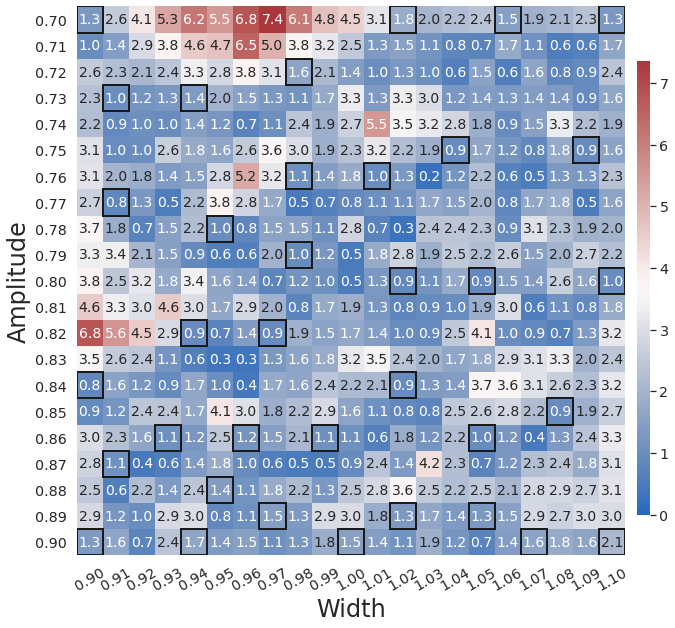

In [16]:
print(f'number of DIs: {len(idx_param)}')
max_err_heatmap(max_err, sindy_idx, params, amp_test, width_test, data_path, idx_list, idx_param,
                xlabel='Width', ylabel='Amplitude', dtype='float')

idx: 0, param: [0.7 0.9]
idx: 420, param: [0.7 1.1]
idx: 20, param: [0.9 0.9]
idx: 440, param: [0.9 1.1]
idx: 28, param: [0.77 0.91]
idx: 299, param: [0.75 1.04]
idx: 177, param: [0.79 0.98]
idx: 271, param: [0.89 1.02]
idx: 166, param: [0.89 0.97]
idx: 96, param: [0.82 0.94]
idx: 14, param: [0.84 0.9 ]
idx: 170, param: [0.72 0.98]
idx: 104, param: [0.9  0.94]
idx: 87, param: [0.73 0.94]
idx: 430, param: [0.8 1.1]
idx: 325, param: [0.8  1.05]
idx: 266, param: [0.84 1.02]
idx: 205, param: [0.86 0.99]
idx: 142, param: [0.86 0.96]
idx: 393, param: [0.85 1.08]
idx: 377, param: [0.9  1.07]
idx: 79, param: [0.86 0.93]
idx: 336, param: [0.7  1.06]
idx: 113, param: [0.78 0.95]
idx: 252, param: [0.7  1.02]
idx: 24, param: [0.73 0.91]
idx: 237, param: [0.76 1.01]
idx: 404, param: [0.75 1.09]
idx: 174, param: [0.76 0.98]
idx: 331, param: [0.86 1.05]
idx: 123, param: [0.88 0.95]
idx: 262, param: [0.8  1.02]
idx: 230, param: [0.9 1. ]
idx: 38, param: [0.87 0.91]
idx: 334, param: [0.89 1.05]
idx: 15

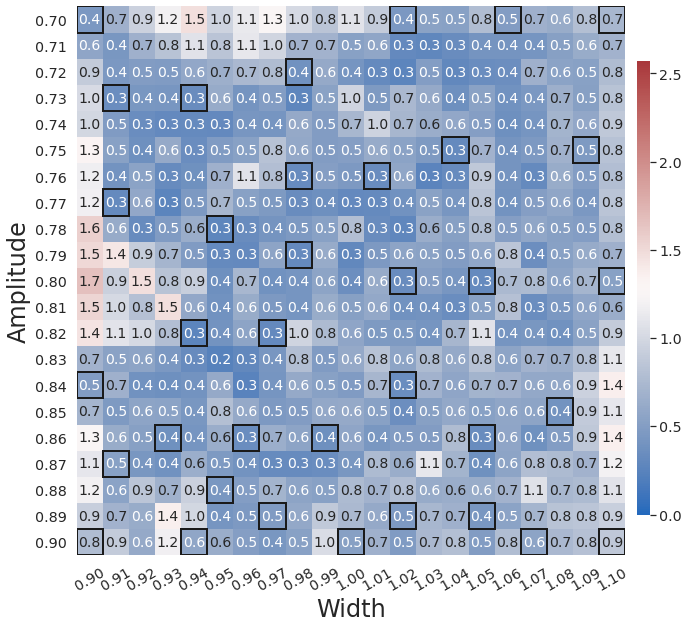

In [17]:
# the residual-based errors are scaled by the "scale" parameter
max_err_heatmap(res_norm, sindy_idx, params, amp_test, width_test, data_path, idx_list, idx_param,
                xlabel='Width', ylabel='Amplitude', label='Residual Norm', dtype='float', scale=100)